### An Example of Applying the SMOTE-Tomek - Augmentation+ downsample 50% majority class+SMOTE-Tomek

Model G9.3, ISIC 2018 dataset, Barata et al. (2021) - ResNet-50 model variant, categorical cross entropy loss function, batch size = 32, lr = 1e-5, augmentation = Yes, SMOTE-Tomek = Yes to 50% of the majority class (3352), with downsampling to 50% majority class, Top 32 layers trainable

In [ ]:
#import necessary libraries
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from zipfile import ZipFile
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, balanced_accuracy_score
from sklearn.metrics import roc_curve, auc
from itertools import cycle
from sklearn.preprocessing import label_binarize
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import layers, models
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.applications.resnet import preprocess_input
import tensorflow as tf
import random

#support for SMOTE-Tomek
from imblearn.combine import SMOTETomek

#save performance metrics
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score
from sklearn.metrics import roc_curve, auc, classification_report
from sklearn.preprocessing import label_binarize
import json

In [ ]:
#setup for reproducibility
IMG_SIZE = (224, 224)
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

#general configuration
LOSS ='categorical_crossentropy'
CLASS_NAMES=['MEL', 'NV', 'BCC', 'AKIEC', 'BKL', 'DF', 'VASC']
AUGMENT_MODES = ['flip_lr', 'flip_ud', 'rot90', 'rot180']

#......................................................................................
checkpoint_path = "/content/drive/MyDrive/Deep Learning/Results/best_model_v9.3.h5"

In [ ]:
#Flags (class with general configurations)
class Flags:
    dim_hidden = 512
    ratio = 8
    learning_rate = 1e-5
    num_classes = 7
    batch_size = 32
    max_epochs = 40 #later dataset testing
    patience = 10
    input_shape = (224, 224, 3)
    use_augmentation = False

In [ ]:
#Attention module
def channel_attention(inputs, ratio=8):
    channel = inputs.shape[-1]
    avg_pool = layers.GlobalAveragePooling2D()(inputs)
    max_pool = layers.GlobalMaxPooling2D()(inputs)
    avg_pool = layers.Reshape((1, 1, channel))(avg_pool)
    max_pool = layers.Reshape((1, 1, channel))(max_pool)

    shared_dense = tf.keras.Sequential([
        layers.Conv2D(channel // ratio, 1, activation='relu', padding='same'),
        layers.Conv2D(channel, 1, padding='same')
    ])

    avg_out = shared_dense(avg_pool)
    max_out = shared_dense(max_pool)
    scale = layers.Activation('sigmoid')(layers.Add()([avg_out, max_out]))
    return layers.Multiply()([inputs, scale])

#Hierachical Attention based module, #build the model, fine-tuning and allowing training from layer 140
def build_resnet50_attention_lstm_model(input_shape=(224, 224, 3), num_classes=Flags.num_classes, learning_rate = Flags.learning_rate):
    input_layer = layers.Input(shape=input_shape)
    base_model = ResNet50(include_top=False, weights='imagenet', input_tensor=input_layer)

    #Ensure “top 32 layers trainable” intent
    for layer in base_model.layers[:-32]:
        layer.trainable = False
    for layer in base_model.layers[-32:]:
        layer.trainable = True

    x = base_model.output
    x = channel_attention(x, ratio=Flags.ratio)
    x = layers.Reshape((-1, 2048))(x)

    avg_feat = layers.GlobalAveragePooling1D()(x)
    init_state = layers.Dense(Flags.dim_hidden * 2, activation='tanh')(avg_feat)
    h_state = layers.Lambda(lambda z: z[:, :Flags.dim_hidden])(init_state)
    c_state = layers.Lambda(lambda z: z[:, Flags.dim_hidden:])(init_state)

    lstm_out, _, _ = layers.LSTM(Flags.dim_hidden, return_sequences=True, return_state=True)(x, initial_state=[h_state, c_state])
    x_proj = layers.Dense(Flags.dim_hidden)(x)
    context = layers.Attention()([lstm_out, x_proj])
    context = layers.GlobalAveragePooling1D()(context)

    x = layers.Concatenate()([context, avg_feat])
    x = layers.Dense(Flags.dim_hidden, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    output = layers.Dense(Flags.num_classes, activation='softmax')(x)

    model = models.Model(inputs=input_layer, outputs=output)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate),loss=LOSS,metrics=['accuracy', tf.keras.metrics.AUC(name='auc')])
    return model

In [ ]:
#.................... Utility Functions ....................

#extracts downloaded data from zip file format
def extract_zip(filename, target_path="."):
    with ZipFile(filename, 'r') as zip_ref:
        zip_ref.extractall(target_path)

#load and process labels
def load_and_process_labels(csv_path):
    df = pd.read_csv(csv_path)

    # Debug: Check if 'image' column exists
    if 'image' not in df.columns:
        print("Error: 'image' column is missing in the dataset")
        raise ValueError("Expected column 'image' in ground-truth CSV")
    else:
        print("Found 'image' column in dataset")

    #Create 'new_image_id' column by appending ".jpg" to the 'image' column values
    df['new_image_id'] = df['image'] + ".jpg"

    #Debug: Verify if 'new_image_id' was created successfully
    print("First few rows with 'new_image_id':")
    print(df[['image', 'new_image_id']].head())  # Print only image and new_image_id columns

    #Create label column from diagnosis columns
    diagnosis_cols = ['MEL', 'NV', 'BCC', 'AKIEC', 'BKL', 'DF', 'VASC']

    #Find the index (i.e., label) where the value is 1
    df['label'] = df[diagnosis_cols].idxmax(axis=1)

    #Map string labels to integers
    label_mapping = {'MEL': 0, 'NV': 1, 'BCC': 2, 'AKIEC': 3, 'BKL': 4, 'DF': 5, 'VASC': 6}
    df['label'] = df['label'].map(label_mapping)

    return df

#determine the distribution of classes in the dataset
def show_class_distribution(y, title="Class Distribution"):
    unique, counts = np.unique(y, return_counts=True)

    class_labels = [
        'Melanoma (0)',         # MEL
        'Nevus (1)',            # NV
        'Basal Cell Carcinoma (2)',  # BCC
        'Actinic Keratosis (3)',     # AKIEC
        'Benign Keratosis (4)',      # BKL
        'Dermatofibroma (5)',        # DF
        'Vascular Lesion (6)'        # VASC
    ]

    print(f"\n{title}:")
    for label, count in zip(unique, counts):
        class_name = class_labels[label] if label < len(class_labels) else f"Unknown Class ({label})"
        print(f"  Class {label} ({class_name}): {count} samples")

#load the image dataset and preprocess e.g. correct color format, resize, map labels
def load_images(df, img_dir):
    #return X, y, ids that actually exist on disk (handles missing files).
    X, y, ids = [], [], []
    for _, row in df.iterrows():
        img_path = os.path.join(img_dir, row['new_image_id'])
        if not os.path.exists(img_path):
            continue
        img = cv2.imread(img_path)
        if img is None:
            continue
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, Flags.input_shape[:2])
        X.append(img.astype('float32') / 255.0)
        y.append(row['label'])
        ids.append(row['new_image_id'])
    X = np.array(X)
    y = np.array(y)
    print(f"Loaded {len(X)} images from {img_dir}")
    return X, y, ids

#show some data samples
def show_samples(X, y, n=6):
    plt.figure(figsize=(12, 5))
    for i in range(min(n, len(X))):
        plt.subplot(2, n // 2, i + 1)
        plt.imshow(X[i])
        plt.title(f"Label: {y[i]}")
        plt.axis("off")
    plt.suptitle('Sample data')
    plt.show()

#training of the model
def train_model(model, X, y, X_val, y_val):
    y_encoded = to_categorical(y, num_classes=Flags.num_classes)
    y_val_encoded = to_categorical(y_val, num_classes=Flags.num_classes)

    early_stop = EarlyStopping(
        monitor='val_auc',   #for imbalance
        mode='max',
        #mode='min',
        patience=Flags.patience,
        restore_best_weights=True,
        verbose=1
    )

    lr_scheduler = ReduceLROnPlateau(
        monitor='val_auc',   #for imbalance
        mode='max',
        factor=0.5,
        patience=2,
        verbose=1,
        min_lr=1e-6
    )

     #......................................
    checkpoint = ModelCheckpoint(
        checkpoint_path,
        monitor='val_auc',
        mode='max',
        save_best_only=True,
        verbose=1
    )
    #......................................


    class PrintLearningRate(tf.keras.callbacks.Callback):
      def on_epoch_end(self, epoch, logs=None):
        lr = tf.keras.backend.get_value(self.model.optimizer.learning_rate)
        val_acc = logs.get('val_accuracy')
        val_loss = logs.get('val_loss')
        val_auc = logs.get('val_auc')
        print(f"\nEpoch {epoch + 1} Summary:")
        print(f"  Learning Rate : {lr:.6f}")
        print(f"  Val Accuracy  : {val_acc:.4f}")
        print(f"  Val Loss      : {val_loss:.4f}")
        if val_auc is not None:
            print(f"  Val AUC       : {val_auc:.4f}")


    history = model.fit(
        X, y_encoded,
        validation_data=(X_val, y_val_encoded),
        epochs=Flags.max_epochs,
        batch_size=Flags.batch_size,
        callbacks=[early_stop, lr_scheduler, checkpoint, PrintLearningRate()],
        shuffle=True
    )
    return history


#evaluate the model based pn metrics e.g. accuracy, precision, recall, sensitivity, specificity
def evaluate_model(y_true, y_pred, y_proba, class_names):
    print("Classification Report:\n", classification_report(y_true, y_pred, target_names=class_names))
    cm = confusion_matrix(y_true, y_pred)

    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=class_names, yticklabels=class_names)
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

    print("\nSensitivity and Specificity per class:")
    for i, cls in enumerate(class_names):
        TP = cm[i, i]
        FN = cm[i, :].sum() - TP
        FP = cm[:, i].sum() - TP
        TN = cm.sum() - (TP + FP + FN)
        sens = TP / (TP + FN) if (TP + FN) > 0 else 0.0
        spec = TN / (TN + FP) if (TN + FP) > 0 else 0.0
        print(f"Class: {cls}")
        print(f"  Sensitivity: {TP / (TP + FN):.4f}")
        print(f"  Specificity: {TN / (TN + FP):.4f}")

    y_true_bin = label_binarize(y_true, classes=np.arange(len(class_names)))
    auc_macro = roc_auc_score(y_true_bin, y_proba, average='macro', multi_class='ovr')
    auc_micro = roc_auc_score(y_true_bin, y_proba, average='micro', multi_class='ovr')
    auc_weighted = roc_auc_score(y_true_bin, y_proba, average='weighted', multi_class='ovr')

    print(f"\nAUC (macro): {auc_macro:.4f}")
    print(f"AUC (micro): {auc_micro:.4f}")
    print(f"AUC (weighted): {auc_weighted:.4f}")

#show training history plot
def plot_history(history):
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy')
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title("Training History")
    plt.xlabel("Epoch")
    plt.ylabel("Metric")
    plt.legend()
    plt.grid(True)

    plt.savefig("/content/drive/MyDrive/Deep Learning/Results/training_history_v9.3.png")
    plt.show()

#plot ROC curve for each class and micro/macro average ROC.
def plot_multiclass_roc(y_true, y_proba, class_names):
    y_true_bin = label_binarize(y_true, classes=np.arange(len(class_names)))
    n_classes = y_true_bin.shape[1]

    #compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_proba[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    #compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y_true_bin.ravel(), y_proba.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    #compute macro-average ROC curve and ROC area
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
    mean_tpr = np.zeros_like(all_fpr)

    for i in range(n_classes):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

    mean_tpr /= n_classes

    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    #plot all ROC curves
    plt.figure(figsize=(10, 8))

    #plot macro and micro averages
    plt.plot(fpr["micro"], tpr["micro"],
             label='Micro-average ROC (area = {0:0.2f})'.format(roc_auc["micro"]),
             linestyle=':', linewidth=4)

    plt.plot(fpr["macro"], tpr["macro"],
             label='Macro-average ROC (area = {0:0.2f})'.format(roc_auc["macro"]),
             linestyle=':', linewidth=4)

    #plot ROC curve for each class
    for i in range(n_classes):
        plt.plot(fpr[i], tpr[i], lw=2,
                 label=f'ROC {class_names[i]} (area = {roc_auc[i]:0.2f})')

    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([-0.02, 1.02])
    plt.ylim([-0.02, 1.02])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Multi-class ROC Curve')
    plt.legend(loc="lower right")
    plt.grid(True)

    plt.savefig("/content/drive/MyDrive/Deep Learning/Results/roc_curve_v9.3.png")
    plt.show()


def load_one_image(img_dir, image_id, size=IMG_SIZE):  # NEW
    p = os.path.join(img_dir, image_id)
    if not os.path.exists(p):
        return None
    img = cv2.imread(p)
    if img is None:
        return None
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, size)
    return img.astype('float32') / 255.0

def augment_image_fixed_np(img_np, mode):
    #img_np is float32 [0,1], HxWx3; returns numpy array
    tf_img = tf.convert_to_tensor(img_np)
    if mode == 'flip_lr':
        tf_img = tf.image.flip_left_right(tf_img)
    elif mode == 'flip_ud':
        tf_img = tf.image.flip_up_down(tf_img)
    elif mode == 'rot90':
        tf_img = tf.image.rot90(tf_img, k=1)
    elif mode == 'rot180':
        tf_img = tf.image.rot90(tf_img, k=2)
    return tf_img.numpy()

def augment_minority_once(train_df, img_dir, aug_modes=AUGMENT_MODES, seed=SEED):
    rng = np.random.default_rng(seed)

    #collect originals per label
    per_label_imgs, per_label_ids = {}, {}
    for lbl in sorted(train_df['label'].unique()):
        per_label_imgs[lbl] = []
        per_label_ids[lbl] = []

    for _, row in train_df.iterrows():
        img = load_one_image(img_dir, row['new_image_id'], size=IMG_SIZE)
        if img is None:
            continue
        lbl = int(row['label'])
        per_label_imgs[lbl].append(img)
        per_label_ids[lbl].append(row['new_image_id'])

    #identify minority labels (strictly less than majority count)
    counts = {lbl: len(per_label_imgs[lbl]) for lbl in per_label_imgs}
    majority_count = max(counts.values()) if counts else 0
    minority_labels = [lbl for lbl, c in counts.items() if c < majority_count]

    #build augmented set
    X_all, y_all, ids_all = [], [], []
    for lbl in per_label_imgs:
        imgs = per_label_imgs[lbl]
        ids  = per_label_ids[lbl]

        #originals
        X_all.extend(imgs)
        y_all.extend([lbl] * len(imgs))
        ids_all.extend(ids)

        #one of each aug op for minority classes
        if lbl in minority_labels:
            for img, id_ in zip(imgs, ids):
                for mode in aug_modes:
                    aug = augment_image_fixed_np(img, mode)
                    X_all.append(aug)
                    y_all.append(lbl)
                    ids_all.append(id_ + f"|aug_{mode}")

    #shuffle
    perm = rng.permutation(len(X_all))
    X_all = np.asarray(X_all, dtype='float32')[perm]
    y_all = np.asarray(y_all, dtype=np.int32)[perm]
    ids_all = [ids_all[i] for i in perm]
    return X_all, y_all, ids_all

In [ ]:
#mount drive (if needed)
from google.colab import drive
drive.mount('/content/drive')

#paths -> Note replace these paths with the paths on appropriate drive e.g. Google drive
train_zip = "/content/drive/MyDrive/Deep Learning/ISIC 2018 Data/ISIC2018_Task3_Training_Input.zip"
test_zip = "/content/drive/MyDrive/Deep Learning/ISIC 2018 Data/ISIC2018_Task3_Test_Input.zip"
val_zip = "/content/drive/MyDrive/Deep Learning/ISIC 2018 Data/ISIC2018_Task3_Validation_Input.zip"
train_csv = "/content/drive/MyDrive/Deep Learning/ISIC 2018 Data/ISIC2018_Task3_Training_GroundTruth.csv"
test_csv = "/content/drive/MyDrive/Deep Learning/ISIC 2018 Data/ISIC2018_Task3_Test_GroundTruth.csv"
val_csv = "/content/drive/MyDrive/Deep Learning/ISIC 2018 Data/ISIC2018_Task3_Validation_GroundTruth.csv"
train_dir = "/content/ISIC2018_Task3_Training_Input"
test_dir = "/content/ISIC2018_Task3_Test_Input"
val_dir = "/content/ISIC2018_Task3_Validation_Input"


Mounted at /content/drive


In [ ]:
#extract and Load
extract_zip(train_zip)
extract_zip(test_zip)
extract_zip(val_zip)

#labels
train_df = load_and_process_labels(train_csv)
test_df  = load_and_process_labels(test_csv)
val_df  = load_and_process_labels(val_csv)

#augment minorities
X_train, y_train, train_ids = augment_minority_once(
        train_df, train_dir, aug_modes=AUGMENT_MODES, seed=SEED)
show_class_distribution(y_train, title="After Minority-Once Augmentation - Training Data")

#load TEST/VAL normally (no augmentation)
X_test,  y_test,  test_ids  = load_images(test_df,  test_dir)
X_val,   y_val,   val_ids   = load_images(val_df,   val_dir)

print(f"After augment-to-target -> X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"Final X_test shape: {X_test.shape}, dtype: {X_test.dtype}")
assert len(X_test.shape) == 4 and X_test.shape[1:] == (224, 224, 3), "X_test shape is invalid"
assert len(X_train.shape) == 4 and X_train.shape[1:] == (224, 224, 3), "X_train shape is invalid"
assert len(X_val.shape)   == 4 and X_val.shape[1:]   == (224, 224, 3), "X_val shape is invalid"


Found 'image' column in dataset
First few rows with 'new_image_id':
          image      new_image_id
0  ISIC_0024306  ISIC_0024306.jpg
1  ISIC_0024307  ISIC_0024307.jpg
2  ISIC_0024308  ISIC_0024308.jpg
3  ISIC_0024309  ISIC_0024309.jpg
4  ISIC_0024310  ISIC_0024310.jpg
Found 'image' column in dataset
First few rows with 'new_image_id':
          image      new_image_id
0  ISIC_0034524  ISIC_0034524.jpg
1  ISIC_0034525  ISIC_0034525.jpg
2  ISIC_0034526  ISIC_0034526.jpg
3  ISIC_0034527  ISIC_0034527.jpg
4  ISIC_0034528  ISIC_0034528.jpg
Found 'image' column in dataset
First few rows with 'new_image_id':
          image      new_image_id
0  ISIC_0034321  ISIC_0034321.jpg
1  ISIC_0034322  ISIC_0034322.jpg
2  ISIC_0034323  ISIC_0034323.jpg
3  ISIC_0034324  ISIC_0034324.jpg
4  ISIC_0034325  ISIC_0034325.jpg

After Minority-Once Augmentation - Training Data:
  Class 0 (Melanoma (0)): 5565 samples
  Class 1 (Nevus (1)): 6705 samples
  Class 2 (Basal Cell Carcinoma (2)): 2570 samples
  Class

In [ ]:
#downsampling
df_idx = pd.DataFrame({'idx': np.arange(len(y_train)), 'label': y_train})
rng = np.random.default_rng(SEED)
df_down = []
for lbl in np.unique(y_train):
  idx_lbl = df_idx[df_idx['label'] == lbl]['idx'].values
  if len(idx_lbl) > 3352:
    keep = rng.choice(idx_lbl, size=3352, replace=False)
  else:
    keep = idx_lbl
  df_down.append(pd.DataFrame({'idx': keep, 'label': lbl}))
df_downsampled = pd.concat(df_down, ignore_index=True)
sel = df_downsampled['idx'].values
X_train = X_train[sel]; y_train = y_train[sel]; train_ids = [train_ids[i] for i in sel]
show_class_distribution(y_train, title="After Downsample  - Training Data")


After Downsample  - Training Data:
  Class 0 (Melanoma (0)): 3352 samples
  Class 1 (Nevus (1)): 3352 samples
  Class 2 (Basal Cell Carcinoma (2)): 2570 samples
  Class 3 (Actinic Keratosis (3)): 1635 samples
  Class 4 (Benign Keratosis (4)): 3352 samples
  Class 5 (Dermatofibroma (5)): 575 samples
  Class 6 (Vascular Lesion (6)): 710 samples


In [ ]:
#applying SMOTE-Tomek
X_train_flat = X_train.reshape((X_train.shape[0], -1))
smote_tomek = SMOTETomek(random_state=SEED)
X_resampled_flat, y_resampled = smote_tomek.fit_resample(X_train_flat, y_train)
X_train = X_resampled_flat.reshape((-1, Flags.input_shape[0], Flags.input_shape[1], 3)).astype('float32')
y_train = y_resampled
show_class_distribution(y_train, title="After SMOTE-Tomek - Training Data")


After SMOTE-Tomek - Training Data:
  Class 0 (Melanoma (0)): 3286 samples
  Class 1 (Nevus (1)): 3284 samples
  Class 2 (Basal Cell Carcinoma (2)): 3342 samples
  Class 3 (Actinic Keratosis (3)): 3352 samples
  Class 4 (Benign Keratosis (4)): 3292 samples
  Class 5 (Dermatofibroma (5)): 3352 samples
  Class 6 (Vascular Lesion (6)): 3352 samples


In [ ]:
#..................... Main Execution .....................

def main():

    #build and train model
    model = build_resnet50_attention_lstm_model(Flags.input_shape, Flags.num_classes, Flags.learning_rate)


    #check which layers are trainable
    print("\nTrainable layers:")
    for layer in model.layers:
        if layer.trainable:
            print(f"  {layer.name}")

    model.summary()

    history = train_model(model, X_train, y_train, X_val, y_val)

    #......................................
    model.load_weights(checkpoint_path)  #Load best model
    if os.path.exists(checkpoint_path):
      model.load_weights(checkpoint_path)
      print("Best checkpoint model loaded.")
    else:
      print("Best checkpoint model not found. Using last trained weights.")

    model.save("/content/drive/MyDrive/Deep Learning/Results/skin_cancer_resnet50_model_best_v9.3.h5")
    #......................................

    #predict and evaluate
    y_proba = model.predict(X_test)
    y_pred = np.argmax(y_proba, axis=1)
    evaluate_model(y_test, y_pred, y_proba, class_names=CLASS_NAMES)
    print(f"Balanced Accuracy (BACC): {balanced_accuracy_score(y_test, y_pred):.4f}")

    plot_multiclass_roc(y_test, y_proba, class_names=CLASS_NAMES)

    #plot training history
    plot_history(history)

    #save prediction results
    results_df = pd.DataFrame({
        'Image': test_df['new_image_id'],
        'True Label': y_test,
        'Predicted Label': y_pred,
        'Correct': (y_test == y_pred).astype(int)
    })

    for i, class_name in enumerate(CLASS_NAMES):
        results_df[f'Prob_{class_name}'] = y_proba[:, i]

    results_df.to_csv("/content/drive/MyDrive/Deep Learning/Results/prediction_results_v9.3.csv", index=False)

    #save performance metrics
    y_true_bin = label_binarize(y_test, classes=np.arange(len(CLASS_NAMES)))

    #get best epoch index based on val_auc
    best_epoch = np.argmax(history.history['val_auc'])

    metrics_dict = {
        'Best Epoch': int(best_epoch + 1),
        'Train Accuracy': history.history['accuracy'][best_epoch],
        'Val Accuracy': history.history['val_accuracy'][best_epoch],
        'Train Loss': history.history['loss'][best_epoch],
        'Val Loss': history.history['val_loss'][best_epoch],
        'Val AUC': history.history['val_auc'][best_epoch],
    }

    #.......................................
    metrics_dict = {
        'Best Epoch': int(best_epoch + 1),
        'Train Accuracy': history.history['accuracy'][best_epoch],
        'Val Accuracy': history.history['val_accuracy'][best_epoch],
        'Train Loss': history.history['loss'][best_epoch],
        'Val Loss': history.history['val_loss'][best_epoch],
        'Val AUC': history.history['val_auc'][best_epoch],
        'Test Accuracy': np.mean(y_pred == y_test),
        'Balanced Accuracy': balanced_accuracy_score(y_test, y_pred),
        'AUC Macro': roc_auc_score(y_true_bin, y_proba, average='macro', multi_class='ovr'),
        'AUC Micro': roc_auc_score(y_true_bin, y_proba, average='micro', multi_class='ovr'),
        'AUC Weighted': roc_auc_score(y_true_bin, y_proba, average='weighted', multi_class='ovr'),
        'F1 Macro': f1_score(y_test, y_pred, average='macro', zero_division=0),
        'F1 Weighted': f1_score(y_test, y_pred, average='weighted', zero_division=0),
        'Recall Macro': recall_score(y_test, y_pred, average='macro', zero_division=0),
        'Sensitivity Macro': recall_score(y_test, y_pred, average='macro', zero_division=0)
    }

    #..........................................

    cm = confusion_matrix(y_test, y_pred)
    for i, class_name in enumerate(CLASS_NAMES):
        TP = cm[i, i]
        FN = cm[i, :].sum() - TP
        FP = cm[:, i].sum() - TP
        TN = cm.sum() - (TP + FP + FN)
        specificity = TN / (TN + FP) if (TN + FP) > 0 else 0.0

        #................................................
        metrics_dict[f'Specificity_{class_name}'] = specificity
        metrics_dict[f'Sensitivity_{class_name}'] = recall_score(y_test == i, y_pred == i, zero_division=0)
        metrics_dict[f'F1_{class_name}'] = f1_score(y_test == i, y_pred == i, zero_division=0)
        metrics_dict[f'Recall_{class_name}'] = recall_score(y_test, y_pred, labels=[i], average=None, zero_division=0)[0]
        fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_proba[:, i])
        metrics_dict[f'ROC_{class_name}'] = auc(fpr, tpr)
        #................................................

    metrics_df = pd.DataFrame([metrics_dict])
    metrics_df.to_csv("/content/drive/MyDrive/Deep Learning/Results/model_metrics_detailed_v9.3.csv", index=False)



94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step

Trainable layers:
  conv5_block1_1_conv
  conv5_block1_1_bn
  conv5_block1_1_relu
  conv5_block1_2_conv
  conv5_block1_2_bn
  conv5_block1_2_relu
  conv5_block1_0_conv
  conv5_block1_3_conv
  conv5_block1_0_bn
  conv5_block1_3_bn
  conv5_block1_add
  conv5_block1_out
  conv5_block2_1_conv
  conv5_block2_1_bn
  conv5_block2_1_relu
  conv5_block2_2_conv
  conv5_block2_2_bn
  conv5_block2_2_relu
  conv5_block2_3_conv
  conv5_block2_3_bn
  conv5_block2_add
  conv5_block2_out
  conv5_block3_1_conv
  conv5_block3_1_bn
  conv5_block3_1_relu
  conv5_block3_2_conv
  conv5_block3_2_bn
  conv5_block3_2_relu
  conv5_block3_3_conv
  conv5_block3_3_bn
  conv5_block3_add
  conv5_block3_out
  global_average_pooling2d
  global_max_pooling2d
  reshape
  reshape_1
  sequential
  add
  activation
  multiply
  reshape_2
  global_average_pooling1d
  dense
  lambda
  lambda_1
  lstm
  dense_1
  attention
  global_average_pooling1d_1
  concatenate
  dense_2


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 34,345,607 (131.02 MB)

 Trainable params: 25,733,895 (98.17 MB)

 Non-trainable params: 8,611,712 (32.85 MB)

Epoch 1/40
727/727 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.2534 - auc: 0.6572 - loss: 1.8006
Epoch 1: val_auc improved from -inf to 0.54991, saving model to /content/drive/MyDrive/Deep Learning/Results/best_model_v9.1-5.h5



Epoch 1 Summary:
  Learning Rate : 0.000010
  Val Accuracy  : 0.1606
  Val Loss      : 2.5133
  Val AUC       : 0.5499
727/727 ━━━━━━━━━━━━━━━━━━━━ 71s 68ms/step - accuracy: 0.2535 - auc: 0.6573 - loss: 1.8004 - val_accuracy: 0.1606 - val_auc: 0.5499 - val_loss: 2.5133 - learning_rate: 1.0000e-05
Epoch 2/40
727/727 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.4844 - auc: 0.8528 - loss: 1.3057
Epoch 2: val_auc improved from 0.54991 to 0.92009, saving model to /content/drive/MyDrive/Deep Learning/Results/best_model_v9.1-5.h5



Epoch 2 Summary:
  Learning Rate : 0.000010
  Val Accuracy  : 0.6788
  Val Loss      : 0.9600
  Val AUC       : 0.9201
727/727 ━━━━━━━━━━━━━━━━━━━━ 41s 56ms/step - accuracy: 0.4844 - auc: 0.8528 - loss: 1.3057 - val_accuracy: 0.6788 - val_auc: 0.9201 - val_loss: 0.9600 - learning_rate: 1.0000e-05
Epoch 3/40
727/727 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.5438 - auc: 0.8836 - loss: 1.1706
Epoch 3: val_auc did not improve from 0.92009

Epoch 3 Summary:
  Learning Rate : 0.000010
  Val Accuracy  : 0.2332
  Val Loss      : 3.3931
  Val AUC       : 0.6378
727/727 ━━━━━━━━━━━━━━━━━━━━ 36s 49ms/step - accuracy: 0.5438 - auc: 0.8836 - loss: 1.1705 - val_accuracy: 0.2332 - val_auc: 0.6378 - val_loss: 3.3931 - learning_rate: 1.0000e-05
Epoch 4/40
727/727 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.5779 - auc: 0.8981 - loss: 1.0989
Epoch 4: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-06.

Epoch 4: val_auc did not improve from 0.92009

Epoch 4 Summary:
  Learning Ra


Epoch 9 Summary:
  Learning Rate : 0.000001
  Val Accuracy  : 0.6632
  Val Loss      : 0.9766
  Val AUC       : 0.9243
727/727 ━━━━━━━━━━━━━━━━━━━━ 41s 57ms/step - accuracy: 0.7187 - auc: 0.9531 - loss: 0.7484 - val_accuracy: 0.6632 - val_auc: 0.9243 - val_loss: 0.9766 - learning_rate: 1.2500e-06
Epoch 10/40
726/727 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.7301 - auc: 0.9569 - loss: 0.7159
Epoch 10: val_auc did not improve from 0.92428

Epoch 10 Summary:
  Learning Rate : 0.000001
  Val Accuracy  : 0.6062
  Val Loss      : 1.0502
  Val AUC       : 0.9127
727/727 ━━━━━━━━━━━━━━━━━━━━ 35s 49ms/step - accuracy: 0.7301 - auc: 0.9569 - loss: 0.7159 - val_accuracy: 0.6062 - val_auc: 0.9127 - val_loss: 1.0502 - learning_rate: 1.2500e-06
Epoch 11/40
727/727 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.7365 - auc: 0.9595 - loss: 0.6944
Epoch 11: val_auc improved from 0.92428 to 0.92445, saving model to /content/drive/MyDrive/Deep Learning/Results/best_model_v9.1-5.h5



Epoch 11 Summary:
  Learning Rate : 0.000001
  Val Accuracy  : 0.6580
  Val Loss      : 0.9665
  Val AUC       : 0.9244
727/727 ━━━━━━━━━━━━━━━━━━━━ 40s 54ms/step - accuracy: 0.7365 - auc: 0.9595 - loss: 0.6943 - val_accuracy: 0.6580 - val_auc: 0.9244 - val_loss: 0.9665 - learning_rate: 1.2500e-06
Epoch 12/40
726/727 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.7489 - auc: 0.9624 - loss: 0.6674
Epoch 12: val_auc did not improve from 0.92445

Epoch 12 Summary:
  Learning Rate : 0.000001
  Val Accuracy  : 0.5492
  Val Loss      : 1.3333
  Val AUC       : 0.8734
727/727 ━━━━━━━━━━━━━━━━━━━━ 35s 48ms/step - accuracy: 0.7489 - auc: 0.9624 - loss: 0.6674 - val_accuracy: 0.5492 - val_auc: 0.8734 - val_loss: 1.3333 - learning_rate: 1.2500e-06
Epoch 13/40
726/727 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.7568 - auc: 0.9643 - loss: 0.6501
Epoch 13: ReduceLROnPlateau reducing learning rate to 1e-06.

Epoch 13: val_auc did not improve from 0.92445

Epoch 13 Summary:
  Learning Rate : 0.0


Epoch 14 Summary:
  Learning Rate : 0.000001
  Val Accuracy  : 0.6684
  Val Loss      : 0.9340
  Val AUC       : 0.9279
727/727 ━━━━━━━━━━━━━━━━━━━━ 40s 55ms/step - accuracy: 0.7664 - auc: 0.9668 - loss: 0.6268 - val_accuracy: 0.6684 - val_auc: 0.9279 - val_loss: 0.9340 - learning_rate: 1.0000e-06
Epoch 15/40
726/727 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.7712 - auc: 0.9687 - loss: 0.6075
Epoch 15: val_auc did not improve from 0.92787

Epoch 15 Summary:
  Learning Rate : 0.000001
  Val Accuracy  : 0.6580
  Val Loss      : 0.9842
  Val AUC       : 0.9217
727/727 ━━━━━━━━━━━━━━━━━━━━ 35s 48ms/step - accuracy: 0.7713 - auc: 0.9687 - loss: 0.6074 - val_accuracy: 0.6580 - val_auc: 0.9217 - val_loss: 0.9842 - learning_rate: 1.0000e-06
Epoch 16/40
726/727 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.7759 - auc: 0.9702 - loss: 0.5925
Epoch 16: val_auc did not improve from 0.92787

Epoch 16 Summary:
  Learning Rate : 0.000001
  Val Accuracy  : 0.6269
  Val Loss      : 1.0488
  Val 


Epoch 21 Summary:
  Learning Rate : 0.000001
  Val Accuracy  : 0.6528
  Val Loss      : 0.9672
  Val AUC       : 0.9281
727/727 ━━━━━━━━━━━━━━━━━━━━ 40s 55ms/step - accuracy: 0.8076 - auc: 0.9769 - loss: 0.5161 - val_accuracy: 0.6528 - val_auc: 0.9281 - val_loss: 0.9672 - learning_rate: 1.0000e-06
Epoch 22/40
727/727 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.8116 - auc: 0.9779 - loss: 0.5044
Epoch 22: val_auc did not improve from 0.92812

Epoch 22 Summary:
  Learning Rate : 0.000001
  Val Accuracy  : 0.6580
  Val Loss      : 0.9929
  Val AUC       : 0.9256
727/727 ━━━━━━━━━━━━━━━━━━━━ 35s 49ms/step - accuracy: 0.8116 - auc: 0.9779 - loss: 0.5044 - val_accuracy: 0.6580 - val_auc: 0.9256 - val_loss: 0.9929 - learning_rate: 1.0000e-06
Epoch 23/40
726/727 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.8186 - auc: 0.9793 - loss: 0.4863
Epoch 23: val_auc did not improve from 0.92812

Epoch 23 Summary:
  Learning Rate : 0.000001
  Val Accuracy  : 0.6425
  Val Loss      : 1.0026
  Val 


Epoch 24 Summary:
  Learning Rate : 0.000001
  Val Accuracy  : 0.6528
  Val Loss      : 0.9317
  Val AUC       : 0.9344
727/727 ━━━━━━━━━━━━━━━━━━━━ 41s 57ms/step - accuracy: 0.8233 - auc: 0.9798 - loss: 0.4787 - val_accuracy: 0.6528 - val_auc: 0.9344 - val_loss: 0.9317 - learning_rate: 1.0000e-06
Epoch 25/40
727/727 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.8272 - auc: 0.9812 - loss: 0.4638
Epoch 25: val_auc did not improve from 0.93438

Epoch 25 Summary:
  Learning Rate : 0.000001
  Val Accuracy  : 0.6425
  Val Loss      : 0.9841
  Val AUC       : 0.9283
727/727 ━━━━━━━━━━━━━━━━━━━━ 35s 48ms/step - accuracy: 0.8272 - auc: 0.9812 - loss: 0.4638 - val_accuracy: 0.6425 - val_auc: 0.9283 - val_loss: 0.9841 - learning_rate: 1.0000e-06
Epoch 26/40
727/727 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.8346 - auc: 0.9820 - loss: 0.4539
Epoch 26: val_auc did not improve from 0.93438

Epoch 26 Summary:
  Learning Rate : 0.000001
  Val Accuracy  : 0.6373
  Val Loss      : 0.9829
  Val 


Epoch 29 Summary:
  Learning Rate : 0.000001
  Val Accuracy  : 0.6632
  Val Loss      : 0.9087
  Val AUC       : 0.9383
727/727 ━━━━━━━━━━━━━━━━━━━━ 39s 54ms/step - accuracy: 0.8513 - auc: 0.9852 - loss: 0.4088 - val_accuracy: 0.6632 - val_auc: 0.9383 - val_loss: 0.9087 - learning_rate: 1.0000e-06
Epoch 30/40
727/727 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.8546 - auc: 0.9855 - loss: 0.4039
Epoch 30: val_auc did not improve from 0.93827

Epoch 30 Summary:
  Learning Rate : 0.000001
  Val Accuracy  : 0.6373
  Val Loss      : 1.0312
  Val AUC       : 0.9254
727/727 ━━━━━━━━━━━━━━━━━━━━ 35s 48ms/step - accuracy: 0.8546 - auc: 0.9855 - loss: 0.4039 - val_accuracy: 0.6373 - val_auc: 0.9254 - val_loss: 1.0312 - learning_rate: 1.0000e-06
Epoch 31/40
727/727 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.8589 - auc: 0.9869 - loss: 0.3877
Epoch 31: val_auc did not improve from 0.93827

Epoch 31 Summary:
  Learning Rate : 0.000001
  Val Accuracy  : 0.6477
  Val Loss      : 0.9990
  Val 

Best checkpoint model loaded.
48/48 ━━━━━━━━━━━━━━━━━━━━ 6s 75ms/step
Classification Report:
               precision    recall  f1-score   support

         MEL       0.29      0.62      0.39       171
          NV       0.92      0.64      0.76       909
         BCC       0.34      0.54      0.41        93
       AKIEC       0.20      0.49      0.29        43
         BKL       0.48      0.35      0.41       217
          DF       0.30      0.41      0.35        44
        VASC       0.53      0.54      0.54        35

    accuracy                           0.58      1512
   macro avg       0.44      0.51      0.45      1512
weighted avg       0.70      0.58      0.61      1512



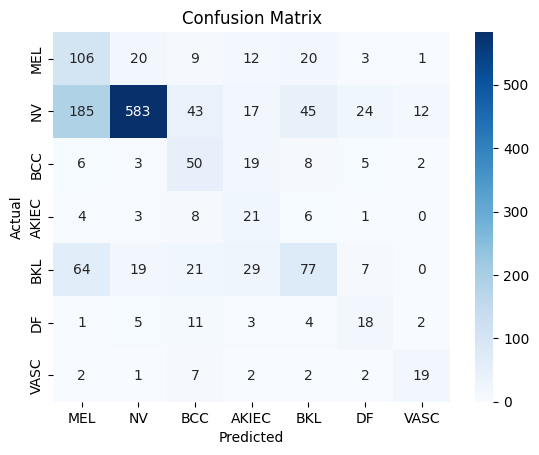


Sensitivity and Specificity per class:
Class: MEL
  Sensitivity: 0.6199
  Specificity: 0.8046
Class: NV
  Sensitivity: 0.6414
  Specificity: 0.9154
Class: BCC
  Sensitivity: 0.5376
  Specificity: 0.9302
Class: AKIEC
  Sensitivity: 0.4884
  Specificity: 0.9442
Class: BKL
  Sensitivity: 0.3548
  Specificity: 0.9344
Class: DF
  Sensitivity: 0.4091
  Specificity: 0.9714
Class: VASC
  Sensitivity: 0.5429
  Specificity: 0.9885

AUC (macro): 0.8692
AUC (micro): 0.9050
AUC (weighted): 0.8660
Balanced Accuracy (BACC): 0.5134


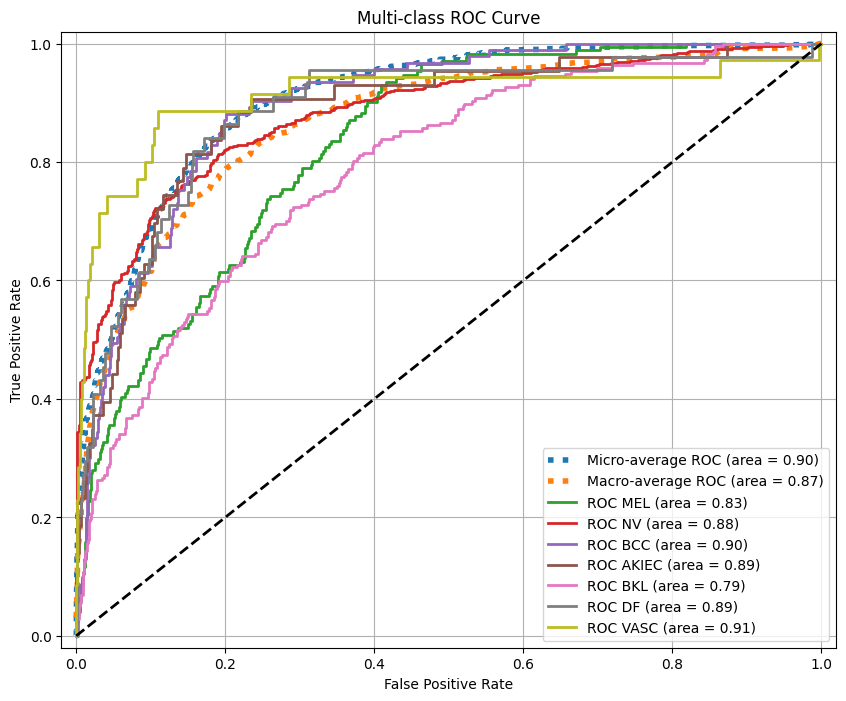

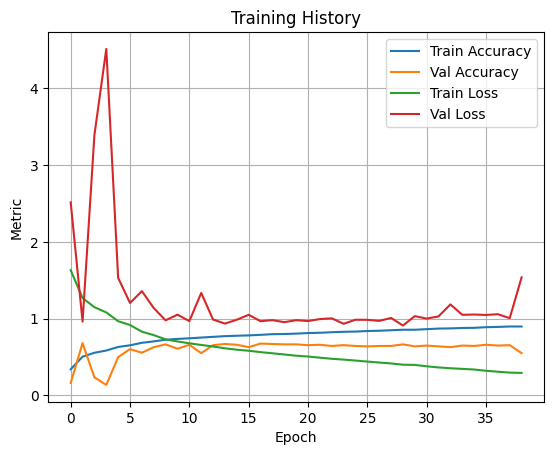

In [ ]:
#run the pipeline
main()